# Assignment - 15 - This is in continuation to the Assignment No 14.

Name : Nihar Kanungo, Manjunath, Bhoomika and Shiv (EVA-2, Batch : 6:30 AM , Sunday)

Background :
-------------
The Purpose of this assignment is to make proper Class and function for each functionality used in the previous Assignment. 

Requirements
--------------

Work on the your own library now:
-------------------------------------------
you should be able to do something like this
1. < Your Library>.data.convert_to_tfRecords(X_train, Y_train)
Now using your library we should be able to do this:
2. < Your Library>.transform(random_pad_crop(random_flip(cutout(rotate(x, 10), 8,8)), 4, 32)

3. < Your Library>.showAndPlotImage(5, 5, misclassified/ParticularClass/Random/MisclassifiedClass


Environment
--------------
Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm : Davidnet






Basic Imports
---------------

In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
from imgaug import augmenters as iaa

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Some more imports which we would be using while reading and writting to Google Drive (for future reference)

In [0]:
import os, sys
from six.moves import cPickle as pickle

from google.colab import drive

#drive.mount('/gdrive')

#!ls "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed"

For running the Eager Execution 

In [0]:
tf.enable_eager_execution()


# Define Hyper Parameters 

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 27 #@param {type:"integer"}

# for deterministic initialization of kernel weights

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

# Define a class which performs convolution followed by Batch Normalization . The method below performs relu activation.

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

# Define the Resnet Block class which would be used in the Davidnet Model 

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

# Define DavidNet model class 

( The details of the model is available in the link https://myrtle.ai/how-to-train-your-resnet/)
-- Added one more value in the return which would help us to find out the misclassified images (Basically the output value)

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    outval = tf.argmax(h, axis = 1)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct,outval.numpy()

# Download the CIFAR data and calculate the mean and standard deviation of the data 

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train/255, axis=(0,1,2))
train_std = np.std(x_train/255, axis=(0,1,2))
hold_x_test = x_test
x_train = x_train/255
x_test = x_test/255



170500096/170498071 [==============================] - 6s 0us/step


# Display the mean and std of each channel

In [0]:
print(train_mean)
print(train_std)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


Now let's define the TF record and see how the training behaves using the Tf record dataset

TFRecord and tf.Example
------------------------
To read data efficiently it can be helpful to serialize your data and store it in a set of files (100-200MB each) that can each be read linearly. This is especially true if the data is being streamed over a network. This can also be useful for caching any data-preprocessing.

The TFRecord format is a simple format for storing a sequence of binary records.


A TFRecord file contains a sequence of records. The file can only be read sequentially.

Each record contains a byte-string, for the data-payload, plus the data-length, and CRC32C (32-bit CRC using the Castagnoli polynomial) hashes for integrity checking.


# TF Record write Functions
------------------
1. Define the tf.examples data type conversion helper functions
2. Define function to write to file as tfrecord 
3. Created a Class tf_record_operations which can be called to convert to TF record 

In [0]:
#!pip install opencv-contrib-python
import cv2
from google.colab.patches import cv2_imshow
class tf_record_operations:
  class data:
    
    def print_progress(count, total):
    # Percentage completion.
      pct_complete = float(count) / total

      # Status-message.
      # Note the \r which means the line should overwrite itself.
      msg = "\r- Progress: {0:.1%}".format(pct_complete)

      # Print it.
      sys.stdout.write(msg)
      sys.stdout.flush()

#conversion sequence
#dataset -> list -> feature -> example -> ToString -> write to file as tfrecord
    def int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def float32_feature(value):
      return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1))) 

    def bytes_feature(value):
      return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

      
    def convert_to_tfRecords(feature= x_train,label=y_train,file_name='train.tfrecords'):
      print('feature is ', len(feature))
      print('label is', len(label))
      print('file is ', file_name)
    # def prepare_tf_records(mode):
      # output_files = {'train': 'train.tfrecords', 'test': 'test.tfrecords'}
      # lengths = {'train': len_train, 'test': len_test}
      # input_data = {'train': x_train, 'test': x_test}
      # output_data = {'train': y_train, 'test': y_test}

      with tf.python_io.TFRecordWriter(file_name) as record_writer:
        num_entries = len(feature)
        data = feature
        labels = label
        print('num_entries = ', num_entries)
        for i in range(num_entries):
          tf_record_operations.data.print_progress(count=i, total=num_entries-1)
          one_image = data[i,::]
          one_label = labels[i]
          #image_size = one_image.shape[0]
          example = tf.train.Example(features=tf.train.Features(
              feature={
                  'image': tf_record_operations.data.float32_feature(one_image), 
                  'label': tf_record_operations.data.int64_feature(one_label)
              }))
          record_writer.write(example.SerializeToString()) 

tf_record_operations.data.convert_to_tfRecords(feature =x_train,label=y_train,file_name='train.tfrecords')
tf_record_operations.data.convert_to_tfRecords(feature =x_test,label=y_test,file_name='test.tfrecords')

feature is  50000
label is 50000
file is  train.tfrecords
num_entries =  50000
- Progress: 100.0%feature is  10000
label is 10000
file is  test.tfrecords
num_entries =  10000
- Progress: 100.0%

# Parser Function

The TFRecords files contain the data in a serialized binary format which needs to be converted back to images and labels of the correct data-type. We use a helper-function for this parsing.

# Read the data 
function  that reads from TFRecords files for use with the davidnet model



In [0]:
#tfrecords file -> tfrecordDataset -> features -> image, label
#parser works on given input(tfrecords file), similar to an apple cutter on a given apple

def parser(serialized_example, img_sz):
  """Parses a single tf.Example into image and label tensors."""
  # Dimensions of the images in the CIFAR-10 dataset.
  # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
  # input format.
  parsed_example = tf.parse_single_example(
      serialized = serialized_example,
      features = {
          'image': tf.FixedLenFeature([img_sz*img_sz*3], tf.float32),
          'label': tf.FixedLenFeature([], tf.int64),
      })

  image = tf.cast(
      tf.reshape(parsed_example['image'], [img_sz, img_sz, 3]),
      tf.float32)
  label = tf.cast(parsed_example['label'], tf.int64)

  # Custom preprocessing.
  #image = self.preprocess(image)

  return image, label

# helper-function for creating an function that reads from TFRecords files for use with the Davidnet Model

def read_tf_records(mode, file_name, image_size):
  # Create a list of filenames and pass it to a queue
  file_names = [file_name]
  raw_dataset = tf.data.TFRecordDataset(file_names)
  parsed_image_dataset = raw_dataset.map(lambda x: parser(x, image_size))
  
  
  
  ####################################
  print("parsed_image_dataset.type() - ", type(parsed_image_dataset))
  print("parsed_image_dataset.dir - ", dir(parsed_image_dataset))
  print("parsed_image_dataset.output_classes - ", tf.compat.v1.data.get_output_classes(parsed_image_dataset))
  print("parsed_image_dataset.output_shapes - ", tf.compat.v1.data.get_output_shapes(parsed_image_dataset))
  print("parsed_image_dataset.output_types - ", tf.compat.v1.data.get_output_types(parsed_image_dataset))
  ####################################
  x = []
  y = []
  for image_features in parsed_image_dataset:
    x.append(image_features[0].numpy()) #image (EagerTensor to numpy array)
    y.append(image_features[1].numpy()) #label (EagerTensor to numpy array)
  print("x.type() - ", type(x))

  x = np.asarray(x) #(numpy array to ndarray)
  y = np.asarray(y) #(numpy array to ndarray)
  return x, y

# Let's store the data read into the variables to be used for training 

x_train, y_train = read_tf_records('train', '/content/train.tfrecords', 32)
x_test, y_test = read_tf_records('test', '/content/test.tfrecords', 32)




parsed_image_dataset.type() -  <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
parsed_image_dataset.dir -  ['_GeneratorState', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_as_variant_tensor', '_checkpoint_dependencies', '_component_metadata', '_consumers', '_dataset', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_from_components', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_ca

# Model object and other features for training 
# Added Lambda functions for 
  1. Random Crop
  2. Radndom Flip
  3. Padding
  4. Random Rotate
  5. Random Cutout 
  6. takes all the above 5 


In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
normalize = lambda x: (tf.cast(x, tf.float32)/255 - train_mean) / train_std
random_crop = lambda x,n: tf.image.random_crop(x, [n, n, 3])
random_flip_left_right = lambda x: tf.image.random_flip_left_right(x)
pad = lambda x, n: tf.pad(x, [[n, n], [n, n], [0, 0]], mode='reflect')
random_rotate = lambda x, n: tf.contrib.image.rotate(x, (np.random.rand()-0.5)*math.pi/180*n)
def cutout(x, si, sj):
    ci = tf.random.uniform((1,), 0, x.shape[0] - si - 1, dtype=tf.int32)[0]
    cj = tf.random.uniform((1,), 0, x.shape[1] - sj - 1, dtype=tf.int32)[0]
    idx = [tf.range(ci, si), tf.range(cj, sj)]
    val = tf.zeros((si, sj, 3))
    tf.tensor_scatter_nd_update(x, idx, val)
    return x
#image_augment = lambda x,y:(normalize(random_crop(pad(random_flip_left_right(cutout(random_rotate(x,10),8,8)),4),32)),y)
image_augment = lambda x,y:(random_crop(pad(random_flip_left_right(cutout(random_rotate(x,10),8,8)),4),32),y)



# This is to check if eager model is running or not 

In [0]:
tf.executing_eagerly()

True

# Model Training and validation 

In [0]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(image_augment).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct,_ = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct,_ = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.6413742028808593 train acc: 0.40234 val loss: 1.5723961364746093 val acc: 0.4346 time: 41.30286526679993



epoch: 2 lr: 0.16 train loss: 0.9498085961914062 train acc: 0.66102 val loss: 1.0488179595947265 val acc: 0.6408 time: 74.0601532459259



epoch: 3 lr: 0.24 train loss: 0.7037655651855469 train acc: 0.75262 val loss: 1.2327735076904296 val acc: 0.6314 time: 107.05212950706482



epoch: 4 lr: 0.32 train loss: 0.6146113442993164 train acc: 0.78704 val loss: 0.876699658203125 val acc: 0.7119 time: 139.31583428382874



epoch: 5 lr: 0.4 train loss: 0.4880178121948242 train acc: 0.83246 val loss: 0.5827254333496094 val acc: 0.8013 time: 171.30679416656494



epoch: 6 lr: 0.38181818181818183 train loss: 0.45654609039306643 train acc: 0.84178 val loss: 0.5908950042724609 val acc: 0.7997 time: 203.6198353767395



epoch: 7 lr: 0.36363636363636365 train loss: 0.35250356994628906 train acc: 0.87886 val loss: 0.5077846221923829 val acc: 0.8248 time: 235.76967930793762



epoch: 8 lr: 0.34545454545454546 train loss: 0.29930635711669923 train acc: 0.89618 val loss: 0.4215864837646484 val acc: 0.8555 time: 268.41789293289185



epoch: 9 lr: 0.32727272727272727 train loss: 0.24466210174560546 train acc: 0.91696 val loss: 0.3955222625732422 val acc: 0.8691 time: 300.63761806488037



epoch: 10 lr: 0.3090909090909091 train loss: 0.21467916458129882 train acc: 0.9259 val loss: 0.5471493133544922 val acc: 0.826 time: 332.6264729499817



epoch: 11 lr: 0.2909090909090909 train loss: 0.18410688980102538 train acc: 0.9354 val loss: 0.3786437942504883 val acc: 0.8757 time: 364.7116918563843



epoch: 12 lr: 0.2727272727272727 train loss: 0.1616353163909912 train acc: 0.944 val loss: 0.3159802734375 val acc: 0.8939 time: 396.9095437526703



epoch: 13 lr: 0.2545454545454545 train loss: 0.13925880031585694 train acc: 0.95258 val loss: 0.3504701599121094 val acc: 0.8866 time: 429.0133054256439



epoch: 14 lr: 0.23636363636363636 train loss: 0.12097068794250489 train acc: 0.95912 val loss: 0.35999470977783204 val acc: 0.8907 time: 461.01111936569214



epoch: 15 lr: 0.21818181818181817 train loss: 0.10303474906921387 train acc: 0.96474 val loss: 0.36747657318115234 val acc: 0.8838 time: 493.13255310058594



epoch: 16 lr: 0.19999999999999998 train loss: 0.15386076591491699 train acc: 0.94462 val loss: 0.33116603927612304 val acc: 0.8976 time: 525.1648421287537



epoch: 17 lr: 0.18181818181818182 train loss: 0.1033475693511963 train acc: 0.96354 val loss: 0.31569445724487305 val acc: 0.9037 time: 557.2672681808472



epoch: 18 lr: 0.16363636363636364 train loss: 0.0698049514389038 train acc: 0.97724 val loss: 0.27343575172424317 val acc: 0.9152 time: 589.4967472553253



epoch: 19 lr: 0.14545454545454545 train loss: 0.056679237785339356 train acc: 0.98152 val loss: 0.2691032257080078 val acc: 0.9172 time: 621.2631640434265



epoch: 20 lr: 0.12727272727272726 train loss: 0.051375700244903566 train acc: 0.98342 val loss: 0.27801663513183594 val acc: 0.9171 time: 653.1429669857025



epoch: 21 lr: 0.10909090909090907 train loss: 0.09414928157806396 train acc: 0.9659 val loss: 0.28799926528930664 val acc: 0.9167 time: 685.0111584663391



epoch: 22 lr: 0.09090909090909088 train loss: 0.05751439790725708 train acc: 0.98108 val loss: 0.2684165710449219 val acc: 0.9216 time: 716.6605610847473



epoch: 23 lr: 0.0727272727272727 train loss: 0.030110789318084717 train acc: 0.99168 val loss: 0.24216360931396486 val acc: 0.9273 time: 748.5485353469849



epoch: 24 lr: 0.05454545454545451 train loss: 0.024659223022460937 train acc: 0.99344 val loss: 0.2518960205078125 val acc: 0.9277 time: 780.612123966217



epoch: 25 lr: 0.03636363636363632 train loss: 0.024011357259750368 train acc: 0.99384 val loss: 0.2468090789794922 val acc: 0.9297 time: 812.4056236743927



epoch: 26 lr: 0.018181818181818132 train loss: 0.05387129560470581 train acc: 0.98208 val loss: 0.26534033737182616 val acc: 0.926 time: 844.132129907608



epoch: 27 lr: 0.0 train loss: 0.01981132781982422 train acc: 0.99532 val loss: 0.24207148818969726 val acc: 0.9308 time: 876.4059164524078


# Find out te predicted class for test data 

In [0]:
model.save_weights('modelweights.h5')
model.load_weights('modelweights.h5')

results = []

for (x, y) in test_set:
    loss, correct, res = model(x, y)
    results.append(res)
    
results = np.concatenate(results)


# Define Plot Function

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_image(nx, ny, X, Y, results=None, ptype='random', pclass=-1):
    l = len(Y)
    idx = np.zeros((nx, ny), dtype='int')
    title = ""
    if ptype == 'random': 
        idx = np.random.randint(0, len(Y), size=(nx, ny))
        title = "Random images"
    elif ptype == 'class':
        if pclass < 0:
            raise Exception("Specific class should be defined.")
        title = "{0:s} class images".format(cifar10_classes[pclass].capitalize())
        k = 0
        for i in range(nx):
            for j in range(ny):
                while Y[k] != pclass: k+=1
                idx[i, j] = k
                k += 1
    elif ptype == 'missed':
        if results is None:
            raise Exception("results cannot be None for misclassified images")
        
        if pclass < 0 :
            title = "Misclassified images"
        else: 
            title = "Misclassified {0:s} class images".format(cifar10_classes[pclass].capitalize())
        
        k = 0
        for i in range(nx):
            if k >= l:
                break
            for j in range(ny):
                if pclass == -1: 
                    while (Y[k] == results[k]): k+=1
                else:
                    while Y[k] != pclass or (Y[k] == results[k]): k+=1
                if k >= l:
                    break
                idx[i, j] = k
                k += 1

    fig, ax = plt.subplots(nx, ny, figsize = (3*nx, 3*ny))
    fig.suptitle(title)
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    
    for (ix, iy) in [(i, j) for i in range(nx) for j in range(ny)]:
        ii = idx[ix, iy]
        ax[ix, iy].imshow(X[ii].astype('uint8'))
        ax[ix, iy].axis('off')
        acls = cifar10_classes[Y[ii]]
        if results is None:
            pcls = "none"
        else:
            pcls = cifar10_classes[results[ii]]
        ax[ix, iy].set_title('%d A: %s P: %s' % (ii, acls, pcls))

# Plot Random Images 

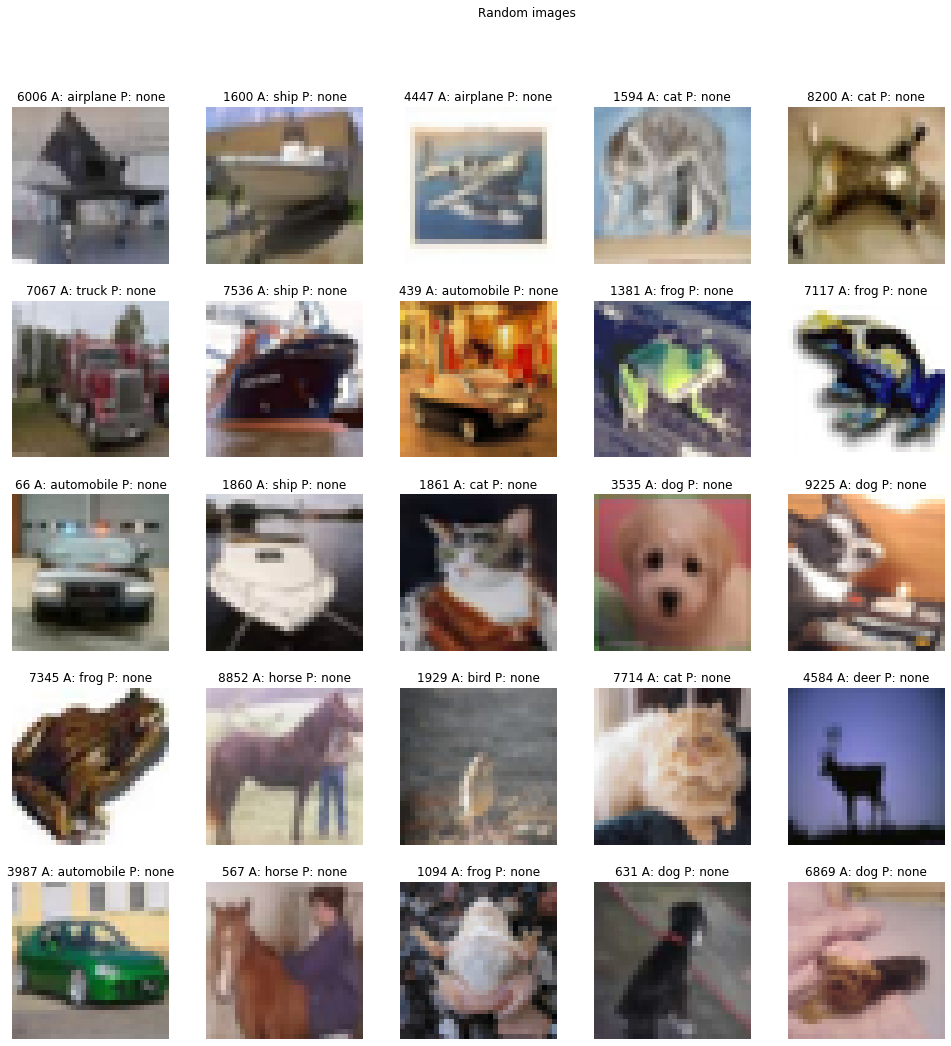

In [0]:
X, Y = hold_x_test, y_test
plot_image(5, 5, X,Y)

# Random  labeled images

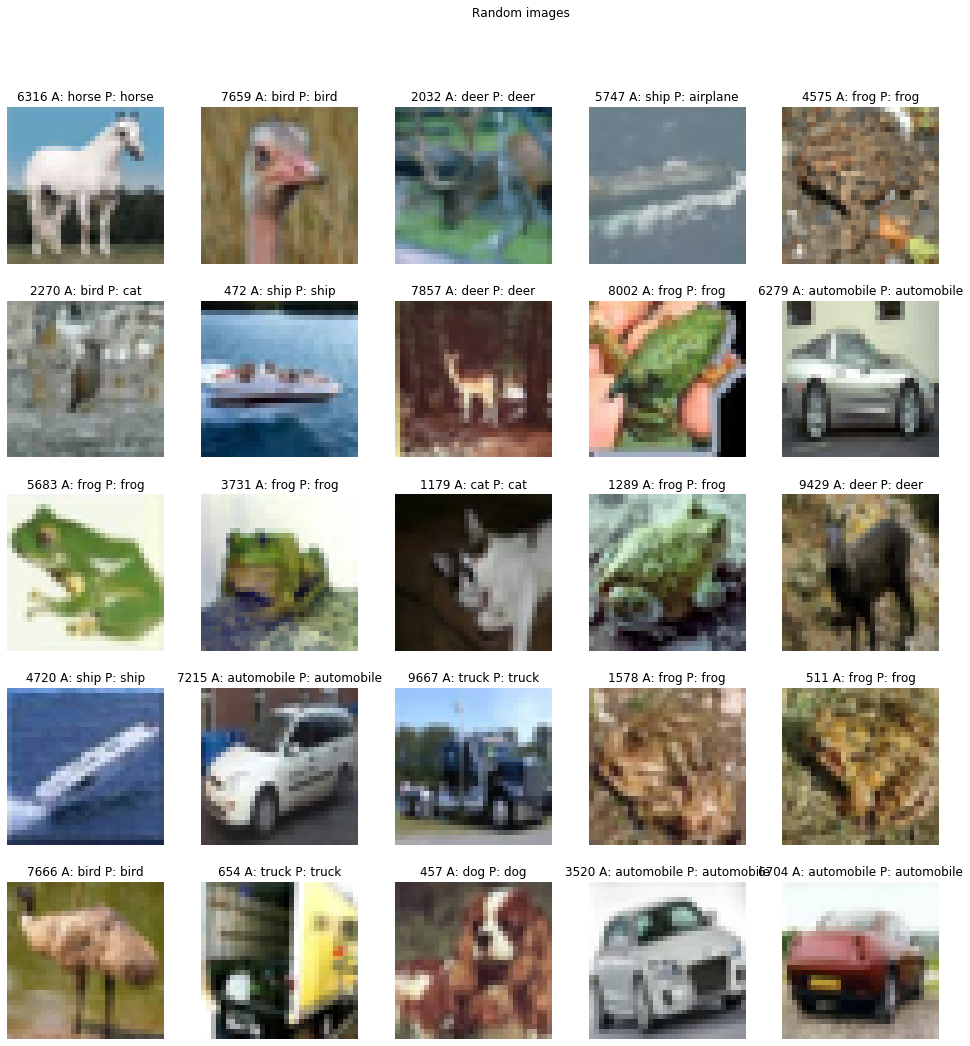

In [0]:
plot_image(5, 5, X, Y, results)

# Class Specific images

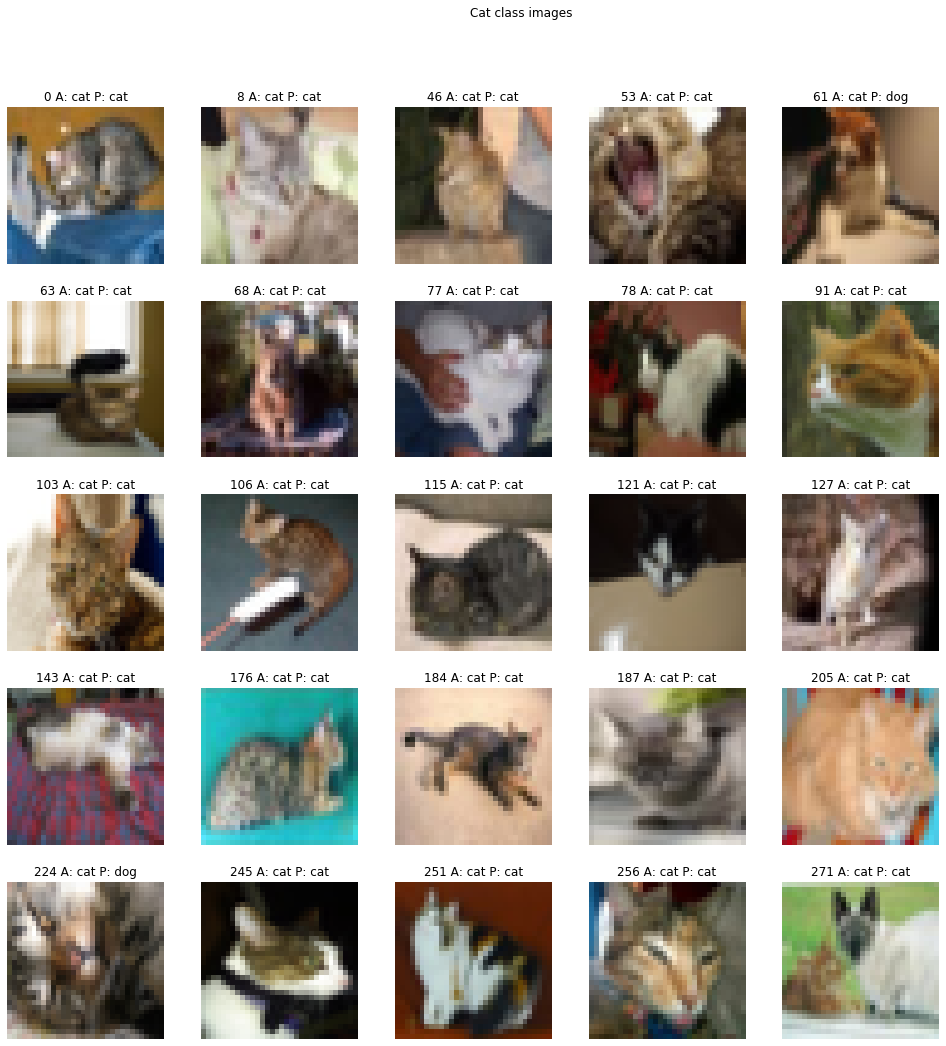

In [0]:
plot_image(5, 5, X, Y, results, ptype='class', pclass=3)

# Misclassified Images

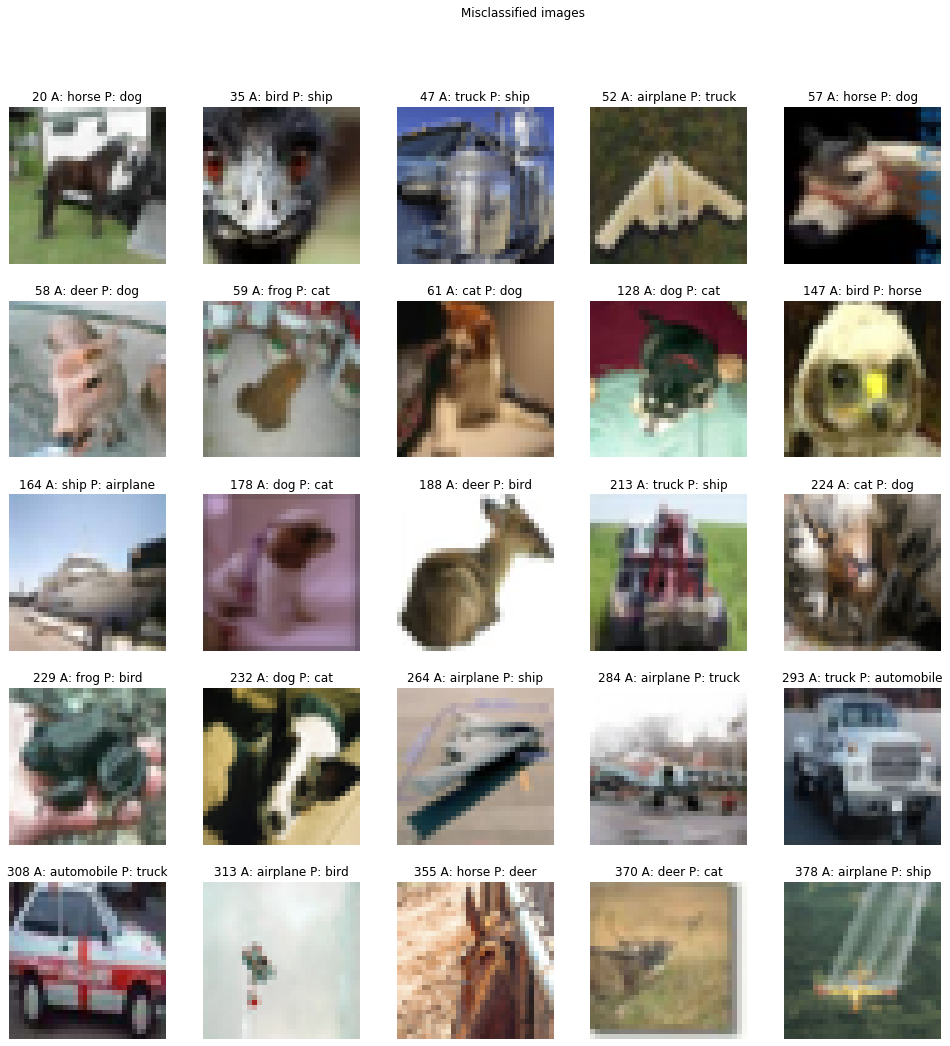

In [0]:
plot_image(5, 5, X, Y, results, ptype='missed')

# MIsclassified Class Images

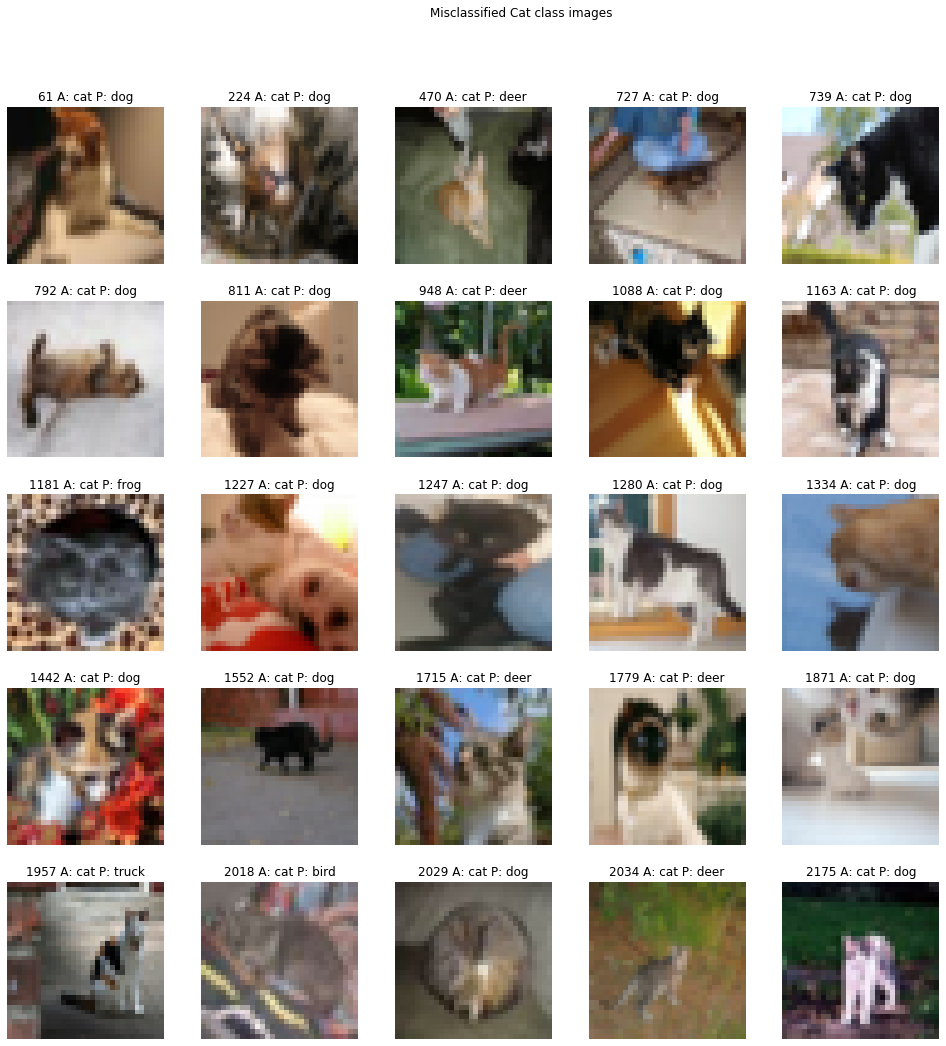

In [0]:
plot_image(5, 5, X, Y, results, ptype='missed', pclass=3)

Observation
------------

The Model ran for 30 epochs in 658 secs with highest validation accuracy of 92.99 %. Now let's run it for few more epochs to see if it's reaching the 93% mark 